In [1]:
%%capture
import sys
!pip install tensorflow-addons
!git clone https://github.com/ICascha/QuantGANs-replication.git
sys.path.append('/content/QuantGANs-replication/')

In [2]:
from backend.preprocessing import *
from backend.metrics import *
from backend.gan import CGAN
from backend.tcn import make_TCN

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm

from tensorflow.random import normal
from tensorflow.keras.utils import Progbar
from datetime import datetime, timedelta

from google.colab import files

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# crsp dataset of jpmc returns and sp500 returns, obtained from wrds
df = pd.read_csv('/content/JPMC_CRSP.csv', parse_dates=['date'], usecols=['RET', 'sprtrn', 'date'])
df = df[(df['date'] >= datetime.strptime('06 03 69', '%d %m %y')) & (df['date'] <= datetime.strptime('01 1 05', '%d %m %y'))]

In [4]:
s1 = StandardScaler()
s2 = StandardScaler()
g1 = Gaussianize()

# receptive field size
rfs = 253

# pre-processing pipeline
log_returns_preprocessed = s2.fit_transform(g1.fit_transform(s1.fit_transform(log_returns)))
log_returns_rolled = rolling_window(log_returns_preprocessed, rfs)

In [5]:
dilations = 2**(np.arange(6))
n_filters = 60

discriminator = make_TCN(dilations, n_filters, False, True, False, [2, 253, 1], block_size=4)
generator = make_TCN(dilations, n_filters, True, False, False, [2*2, None, 3], prune_last=True, prefix=True)

In [6]:
from tensorflow.keras.layers import PReLU, Conv1D, Add, Input, Activation, Cropping2D, ZeroPadding2D, Conv2D, Concatenate, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.compat.v1.keras.layers import BatchNormalization
from tensorflow_addons.layers import SpectralNormalization
import tensorflow.keras.backend as K

import tensorflow as tf




def add_temporal_block(prev_layer, skip_layer, kernel_size, dilation, n_filters, n_series, rfs, block_size, use_batchNorm, cropping):
    """Creates a temporal block.

    Args:
        prev_layer (tensorflow.keras.layers.Layer): previous layer to attach to on standard path.
        skip_layer (tensorflow.keras.layers.Layer): previous layer to attach to on the skip path.
        kernel_size (int): kernel size of convolution layers within the temporal block.
        dilation (int): dilation of convolution layers within the temporal block.
        n_filters (int): Number of channels to use within the temporal block.
        n_series (int): Number of timeseries to model.
        rfs (int): Receptive field size of the network.
        block_size (int): Number of convolution layers to use within a temporal block.
        use_batchNorm (bool): Whether to use batch normalization (with renormalization).

    Returns:
        tuple of tensorflow.keras.layers.Layer: Output layers belonging to (normal path, skip path).
    """
    convs = []
    for _ in range(n_series):
        convs.append(SpectralNormalization(Conv2D(n_filters, (n_series, kernel_size), dilation_rate=(1, dilation)))(prev_layer))

    if len(convs) == 1:
        block = convs[0]
    else:
        block = Concatenate(axis=1)(convs)

    block = PReLU(shared_axes=[1, 2, 3])(block)

    if use_batchNorm:
        block = BatchNormalization(axis=3, momentum=.9, epsilon=1e-5, renorm=True, renorm_momentum=.9)(block)

    for _ in range(block_size - 1):
        convs = []
        for _ in range(n_series):
            convs.append(SpectralNormalization(Conv2D(n_filters, (n_series, kernel_size), dilation_rate=(1, dilation)))(block))
            
        if len(convs) == 1:
            block = convs[0]
        else:
            block = Concatenate(axis=1)(convs)

        block = PReLU(shared_axes=[1, 2, 3])(block)
        if use_batchNorm:
            block = BatchNormalization(axis=3, momentum=.9, epsilon=1e-5, renorm=True, renorm_momentum=.9)(block)
        
    if kernel_size != 1:
        drop_left = block_size * (kernel_size - 1) * dilation
        cropping += drop_left
    else:
        # upsample channel axis
        prev_layer = Conv2D(n_filters, 1)(prev_layer)
        # add residual connections        
        out = Add()([prev_layer,block])
        # crop from left side for skip path
        skip_out = Cropping2D(cropping=((0,0), (rfs-1, 0)))(out)
        # add 1x1 convolution to skip path
        skip_out = SpectralNormalization(Conv2D(n_filters, 1))(skip_out)

        return PReLU(shared_axes=[1, 2, 3])(out), skip_out, cropping
    # add residual connections
    out = Add()([Cropping2D(cropping=((0,0), (drop_left, 0)))(prev_layer), block])
    # crop from left side for skip path
    skip_out = Cropping2D(cropping=((0,0), (rfs-1-cropping, 0)))(out)
    # add current output with 1x1 conv to skip path
    skip_out = Add()([skip_layer, SpectralNormalization(Conv2D(n_filters, 1))(skip_out)])

    return PReLU(shared_axes=[1, 2, 3])(out), skip_out, cropping
	
def make_TCN(dilations, n_filters, use_batchNorm, one_series_output, sigmoid, input_dim, block_size=2, mean_timesteps=False, prune_last=False, prefix=False):
    """Creates a causal temporal convolutional network with skip connections.
       This network uses 2D convolutions in order to model multiple timeseries co-dependency.

    Args:
        dilations (list, tuple): Ordered number of dilations to use for the temporal blocks.
        n_filters (int): Number of channels in the hidden layers.
        use_batchNorm (int): Whether to use batch normalization in the temporal blocks. Includes batch Renormalization.
        sigmoid (bool): Whether to append the sigmoid activation function at the output of the network.
        input_dim (list, tuple): Input dimension of the shape (number of timeseries, timesteps, number of features). Timesteps may be None for variable length timeseries. 
        block_size (int): How many convolution layers to use within a temporal block. Defaults to 2.

    Returns:
        tensorflow.keras.models.Model: a non-compiled keras model.
    """    
    rfs = receptive_field_size(dilations, block_size)
    n_series = input_dim[0]

    input_layer = Input(shape=input_dim)

    prev_layer, skip_layer, _ = add_temporal_block(input_layer, None, 1, 1, n_filters, n_series, rfs, block_size, use_batchNorm, None)
                
    cropping = 0
    for dilation in dilations:
        prev_layer, skip_layer, cropping = add_temporal_block(prev_layer, skip_layer, 2, dilation, n_filters, n_series, rfs, block_size, use_batchNorm, cropping)
        
    if prune_last:
        skip_layer = Cropping2D(((0, 2), (0, 0)))(skip_layer)

    if mean_timesteps:
        skip_layer = Lambda(lambda x: K.mean(x, axis=2, keepdims=True))(skip_layer)

    output_layer = PReLU(shared_axes=[1, 2, 3])(skip_layer)
    output_layer = SpectralNormalization(Conv2D(n_filters, kernel_size=1))(output_layer)
    output_layer = PReLU(shared_axes=[1, 2, 3])(output_layer)
    output_layer = SpectralNormalization(Conv2D(1, kernel_size=1))(output_layer)

    if one_series_output:
        PReLU(shared_axes=[1, 2, 3])(skip_layer)
        output_layer = SpectralNormalization(Conv2D(1, (n_series, 1)))(output_layer)

    if sigmoid:
        output_layer = Activation('sigmoid')(output_layer)

    if prefix:
        input_layer_real = Input(shape=[2, None, 1])
        output_layer_conc = Concatenate(axis=2)([input_layer_real, output_layer])

        return Model([input_layer_real, input_layer], output_layer_conc)

    return Model(input_layer, output_layer)
	
def receptive_field_size(dilations, block_size):
    """Non-exhaustive computation of receptive field size.

    Args:
        dilations (list, tuple): Ordered number of dilations of the network.
        block_size (int): Number of convolution layers in each temporal block of the network.

    Returns:
        int: the receptive field size.
    """    
    return 1 + block_size * sum(dilations)

In [7]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Progbar
from tensorflow.keras.models import load_model
from tensorflow import convert_to_tensor

import tensorflow as tf
import numpy as np
import pickle

class GAN:

    # This method returns a helper function to compute cross entropy loss
    cross_entropy = BinaryCrossentropy(from_logits=True)

    @staticmethod
    def discriminator_loss(real_output, fake_output):
        real_loss = GAN.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = GAN.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    @staticmethod
    def generator_loss(fake_output):
        return GAN.cross_entropy(tf.ones_like(fake_output), fake_output)

    def __init__(self, discriminator, generator, lr_d=1e-4, lr_g=3e-4, epsilon=1e-8, beta_1=0, beta_2=0.9):
        self.disc_input = discriminator.input_shape
        self.discriminator = discriminator
        self.generator = generator

        self.generator_optimizer = Adam(lr_d, epsilon=epsilon, beta_1=beta_1, beta_2=beta_2)
        self.discriminator_optimizer = Adam(lr_g, epsilon=epsilon, beta_1=beta_1, beta_2=beta_2)

    def train(self, data, batch_size, n_batches, additional_d_steps):
        """[summary]
        Args:
            data ([type]): [description]
            batch_size ([type]): [description]
            n_batches ([type]): [description]
            additional_d_steps ([type]): [description]
        """ 
        progress = Progbar(n_batches)

        for n_batch in range(n_batches):

            batch_idx = np.random.choice(np.arange(data.shape[0]), size=batch_size, replace=(batch_size > data.shape[0]))
            batch = data[batch_idx]

            self.train_step(batch, batch_size, additional_d_steps)

            self.train_hook(n_batch)

            progress.update(n_batch + 1)

    @tf.function
    def train_step(self, data, batch_size, additional_d_steps):

        for _ in range(additional_d_steps):
            noise = tf.random.normal([batch_size, self.disc_input[1], self.disc_input[2]*2 - 1, 3])
            generated_data = self.generator(noise, training=False)

            with tf.GradientTape() as disc_tape:
                real_output = self.discriminator(data, training=True)
                fake_output = self.discriminator(generated_data, training=True)
                disc_loss = GAN.discriminator_loss(real_output, fake_output)

            gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
            self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        noise = tf.random.normal([batch_size, self.disc_input[1], self.disc_input[2]*2 - 1, 3])
        generated_data = self.generator(noise, training=False)

        with tf.GradientTape() as disc_tape:
            real_output = self.discriminator(data, training=True)
            fake_output = self.discriminator(generated_data, training=True)

            disc_loss = GAN.discriminator_loss(real_output, fake_output)

        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        noise = tf.random.normal([batch_size, self.disc_input[1], self.disc_input[2]*2 - 1, 3])
        with tf.GradientTape() as gen_tape:
            generated_data = self.generator(noise, training=True)
            fake_output = self.discriminator(generated_data, training=False)
            gen_loss = GAN.generator_loss(fake_output)
            gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

    def save(self, folder_path):
        self.generator.save(folder_path)

    def load(folder_path):
        generator = load_model(folder_path)

        return generator

    def train_hook(self, n_batch):
        pass

class verboseGAN(GAN):

    def train(self, data, batch_size, n_batches, additional_d_steps):
        """[summary]

        Args:
            data ([type]): [description]
            batch_size ([type]): [description]
            n_batches ([type]): [description]
            additional_d_steps ([type]): [description]
        """ 
        progress = Progbar(n_batches)

        for n_batch in range(n_batches):

            batch_idx = np.random.choice(np.arange(data.shape[0]), size=batch_size, replace=(batch_size > data.shape[0]))
            batch = data[batch_idx]
            self.train_step(batch, batch_size, additional_d_steps)

            self.train_hook(n_batch)

            progress.update(n_batch + 1)

    @tf.function
    def train_step(self, data, batch_size, additional_d_steps):

        for _ in range(additional_d_steps):
            pass

        noise = tf.concat([tf.zeros([batch_size, 2, 126, 3]), tf.random.normal([batch_size, 2, 127, 3])], axis=2)
        real_part = tf.repeat(tf.concat([convert_to_tensor(data[:, :, :126, :]), tf.zeros([batch_size, 2, 127, 1])], axis=2), 3, axis=3)

        noise_input = tf.concat([real_part, noise], axis=1)

        generated_data = self.generator([data[:, :, :126, :], noise_input], training=False)


        with tf.GradientTape() as disc_tape:
            real_output = self.discriminator(data, training=True)
            fake_output = self.discriminator(generated_data, training=True)

            disc_loss = GAN.discriminator_loss(real_output, fake_output)

        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        
        noise = tf.concat([tf.zeros([batch_size, 2, 126, 3]), tf.random.normal([batch_size, 2, 127, 3])], axis=2)
        real_part = tf.repeat(tf.concat([convert_to_tensor(data[:, :, :126, :]), tf.zeros([batch_size, 2, 127, 1])], axis=2), 3, axis=3)

        noise_input = tf.concat([real_part, noise], axis=1)

        with tf.GradientTape() as gen_tape:
            generated_data = self.generator([data[:, :, :126, :], noise_input], training=True)
            fake_output = self.discriminator(generated_data, training=False)
            gen_loss = GAN.generator_loss(fake_output)
            gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        
gan = verboseGAN(discriminator, generator, lr_d=3e-4, lr_g=1e-4)

In [8]:
data = np.expand_dims(np.moveaxis(np.moveaxis(log_returns_rolled, 0, 1), 1, 2), -1).astype('float32')
batch_size = 128
n_batches = 2000
additional_d_steps = 0
# have trained an additional ~4000 steps before
gan.train(data, batch_size, n_batches, additional_d_steps)

2000/2000 [==============================] - 2444s 1s/step


In [9]:
%%capture
generator.save('trained_jpmc_generator_05')
!zip -r trained_jpmc_generator_05.zip trained_jpmc_generator_05/

INFO:tensorflow:Assets written to: trained_jpmc_generator_05/assets


In [10]:
files.download('trained_jpmc_generator_05.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
df = pd.read_csv('/content/JPMC_CRSP.csv', parse_dates=['date'], usecols=['RET', 'sprtrn', 'date'])
df = df[(df['date'] >= datetime.strptime('06 03 69', '%d %m %y'))]
log_returns = df[['RET', 'sprtrn']].astype('float64').to_numpy()

# receptive field size
rfs = 126

# pre-processing pipeline
log_returns_preprocessed = s1.fit_transform(log_returns)
log_returns_rolled = rolling_window(log_returns_preprocessed, rfs)

data = np.expand_dims(np.moveaxis(np.moveaxis(log_returns_rolled, 0, 1), 1, 2), -1).astype('float32')

q = 0.90
sim_size = 256
step_size = 15
asset = 0 # condition on JPMC
progress = Progbar(len(data)//step_size + 1)
delta_covar = np.zeros([data.shape[0]//step_size + 1, data.shape[1]])

j = 0
for i in range(0, len(data), step_size):

    noise = tf.concat([tf.zeros([sim_size, data.shape[1], 126, 3]), tf.random.normal([sim_size, data.shape[1], 127, 3])], axis=2)
    real_part = tf.repeat(tf.concat([convert_to_tensor(np.repeat(np.expand_dims(data[i], 0), sim_size, 0)), tf.zeros([sim_size, data.shape[1], 127, 1])], axis=2), 3, axis=3)
    noise_input = tf.concat([real_part, noise], axis=1)

    # transform to losses
    z = -1 * generator([np.repeat(np.expand_dims(data[i], 0), sim_size, 0), noise_input], training=False).numpy().squeeze()
    z = np.moveaxis(z, 0, 1)[:, :, 126:]

    VaR_mask_50 = z[asset] >= np.quantile(z[asset], .5)
    VaR_mask_q = z[asset] >= np.quantile(z[asset], q)

    delta_covar[j] = np.quantile(z[:, VaR_mask_q], q, axis=1) - np.quantile(z[:, VaR_mask_50], q, axis=1)
    j += 1

    progress.update(j)

864/864 [==============================] - 204s 236ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

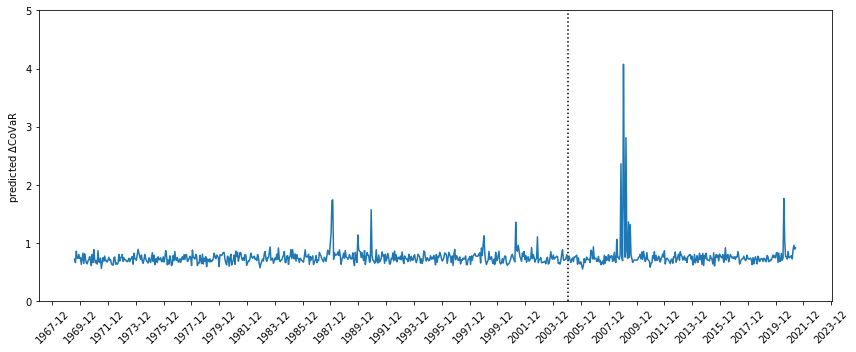

In [12]:
xticks = pd.DatetimeIndex(np.linspace((df['date'].min() + timedelta(days=127)).value, (df['date'].max() + timedelta(days=127)).value , num=len(delta_covar), dtype='int64'))

fig, ax = plt.subplots(figsize=(12, 5), nrows=1)
ax.plot(xticks, delta_covar[:, 1]);

fmt = mdates.MonthLocator(interval=24)
ax.xaxis.set_major_locator(fmt)

ax.vlines(datetime.strptime('01 1 05', '%d %m %y'), 0, 10, linestyles='dotted')
ax.set_ylim(0, 5)
plt.xticks(rotation=45)
ax.set_ylabel('predicted $\Delta$CoVaR')
plt.tight_layout();

plt.savefig('dcovar_jpmc.png', dpi=300)
files.download('dcovar_jpmc.png')

In [13]:
df_covar = pd.read_csv('/content/CoVaR_weekly_jpmc.csv', usecols=['week', 'DCoVaR_CS_p95'])
df_covar['week'] = pd.to_datetime(df_covar['week'])
df_covar = df_covar[(df_covar['week'] >= np.datetime64('2007-01-01')) & (df_covar['week'] <= np.datetime64('2011-01-01'))]

In [14]:
day_offset = timedelta(days=126 + 127//2)  #note that the offset is divisible by 7
# so day - offset is still a friday
df = df.set_index('date')

days = df.index[df.index.isin(df_covar['week'] - day_offset)]
pred_covar = np.zeros((len(days), 5))
q = 0.90
sim_size = 256
asset = 0

for i, day in enumerate(days):

    idx = np.flatnonzero(df.index == day)

    for lag in range(0, 5):
        idx_lagged = idx.item() - lag
        window = df.iloc[idx_lagged:idx_lagged+126].to_numpy()

        data = np.expand_dims(s1.transform(window).T, -1).astype('float32')

        noise = tf.concat([tf.zeros([sim_size, data.shape[0], 126, 3]), tf.random.normal([sim_size, data.shape[0], 127, 3])], axis=2)
        real_part = tf.repeat(tf.concat([convert_to_tensor(np.repeat(np.expand_dims(data, 0), sim_size, 0)), tf.zeros([sim_size, data.shape[0], 127, 1])], axis=2), 3, axis=3)
        noise_input = tf.concat([real_part, noise], axis=1)

        z = -1 * generator([np.repeat(np.expand_dims(data, 0), sim_size, 0), noise_input], training=False).numpy().squeeze()
        z = np.moveaxis(z, 0, 1)[:, :, 126:]

        VaR_mask_50 = z[asset] >= np.quantile(z[asset], .5)
        VaR_mask_q = z[asset] >= np.quantile(z[asset], q)

        delta_covar = np.quantile(z[:, VaR_mask_q], q, axis=1) - np.quantile(z[:, VaR_mask_50], q, axis=1)
        
        pred_covar[i, lag] = delta_covar[1]

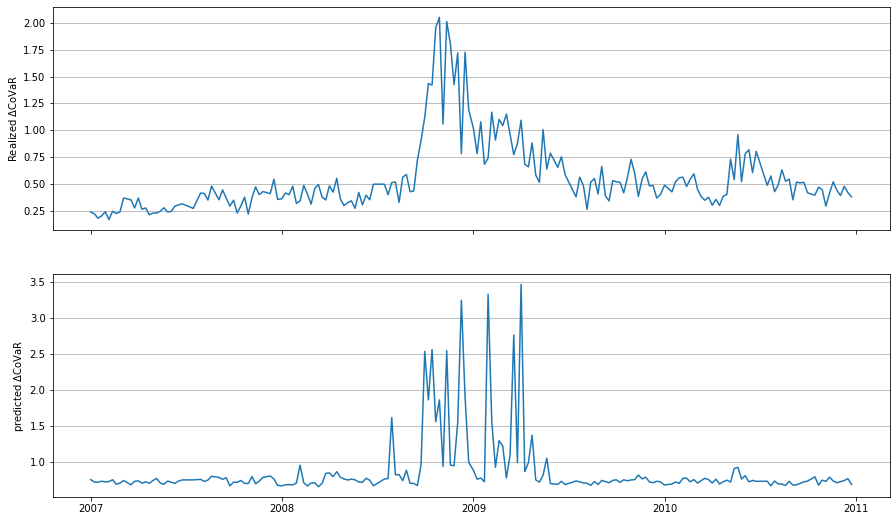

In [15]:
fig, ax = plt.subplots(figsize=(15, 10), nrows=2, sharex=True)


y_plot = df_covar.set_index('week').loc[df.index[df.index.isin(df_covar['week'] - day_offset)] + day_offset]['DCoVaR_CS_p95']
y_plot.plot(ax=ax[0])
ax[1].plot(y_plot.index, pred_covar.mean(axis=1)[:len(y_plot)])

fmt = mdates.YearLocator()
ax[1].xaxis.set_major_locator(fmt)

myFmt = mdates.DateFormatter('%Y')
ax[1].xaxis.set_major_formatter(myFmt)

plt.minorticks_off();

ax[0].yaxis.grid(zorder=0)
ax[1].yaxis.grid(zorder=0)

ax[0].set_ylabel('Realized $\Delta$CoVaR')
ax[1].set_ylabel('predicted $\Delta$CoVaR')

plt.savefig('pred_vs_real_covar.png', dpi=300)

In [16]:
y = df_covar.set_index('week').loc[df.index[df.index.isin(df_covar['week'] - day_offset)] + day_offset]['DCoVaR_CS_p95']
X = np.vstack([y.shift(), pred_covar.mean(axis=1)])
X = sm.add_constant(X.T)
model = sm.OLS(y, X, missing='drop')
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          DCoVaR_CS_p95   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     213.3
Date:                Wed, 23 Jun 2021   Prob (F-statistic):           3.48e-49
Time:                        22:56:44   Log-Likelihood:                 46.356
No. Observations:                 192   AIC:                            -86.71
Df Residuals:                     189   BIC:                            -76.94
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0163      0.032      0.510      0.6

In [17]:
y = df_covar.set_index('week').loc[df.index[df.index.isin(df_covar['week'] - day_offset)] + day_offset]['DCoVaR_CS_p95']
X = pred_covar.mean(axis=1)
X = sm.add_constant(X.T)
model = sm.OLS(y, X, missing='drop')
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          DCoVaR_CS_p95   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     92.60
Date:                Wed, 23 Jun 2021   Prob (F-statistic):           4.03e-18
Time:                        22:56:47   Log-Likelihood:                -29.128
No. Observations:                 193   AIC:                             62.26
Df Residuals:                     191   BIC:                             68.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1710      0.045      3.836      0.0

In [18]:
y = df_covar.set_index('week').loc[df.index[df.index.isin(df_covar['week'] - day_offset)] + day_offset]['DCoVaR_CS_p95']
X = pred_covar.T
X = sm.add_constant(X.T)
model = sm.OLS(y, X, missing='drop')
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          DCoVaR_CS_p95   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     29.09
Date:                Wed, 23 Jun 2021   Prob (F-statistic):           8.91e-22
Time:                        22:56:50   Log-Likelihood:                -11.755
No. Observations:                 193   AIC:                             35.51
Df Residuals:                     187   BIC:                             55.09
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0248      0.053      0.468      0.6

In [19]:
df = pd.read_csv('/content/JPMC_CRSP.csv', parse_dates=['date'], usecols=['RET', 'sprtrn', 'date'])
df = df[(df['date'] >= datetime.strptime('06 03 69', '%d %m %y'))]
log_returns = df[['RET', 'sprtrn']].astype('float64').to_numpy()

# receptive field size
rfs = 126

# pre-processing pipeline
log_returns_preprocessed = s1.fit_transform(log_returns)
log_returns_rolled = rolling_window(log_returns_preprocessed, rfs)

data = np.expand_dims(np.moveaxis(np.moveaxis(log_returns_rolled, 0, 1), 1, 2), -1).astype('float32')

q = 0.90
sim_size = 256
step_size = 15
asset = 0 # condition on JPMC
progress = Progbar(len(data)//step_size + 1)
delta_covar = np.zeros([data.shape[0]//step_size + 1, data.shape[1]])

j = 0
for i in range(0, len(data), step_size):

    z = data[i]*-1

    VaR_mask_50 = z[asset] >= np.quantile(z[asset], .5)
    VaR_mask_q = z[asset] >= np.quantile(z[asset], q)

    delta_covar[j] = np.quantile(z[:, VaR_mask_q], q, axis=1) - np.quantile(z[:, VaR_mask_50], q, axis=1)
    j += 1

    progress.update(j)

864/864 [==============================] - 0s 460us/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

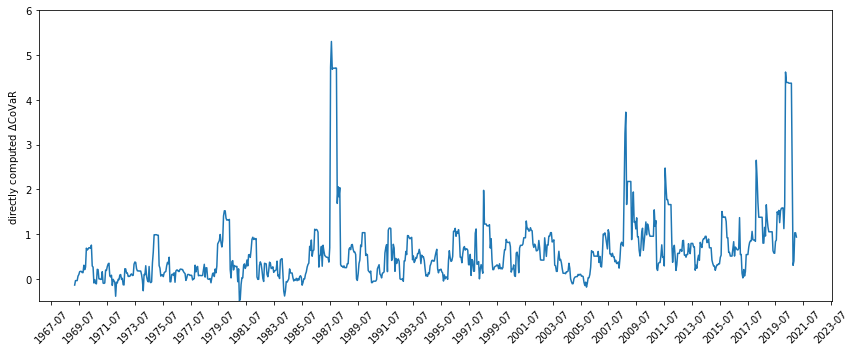

In [20]:
xticks = pd.DatetimeIndex(np.linspace(df['date'].min().value, df['date'].max().value, num=len(delta_covar), dtype='int64'))

fig, ax = plt.subplots(figsize=(12, 5), nrows=1)
ax.plot(xticks, delta_covar[:, 1]);

fmt = mdates.MonthLocator(interval=24)
ax.xaxis.set_major_locator(fmt)
ax.set_ylim(-0.5, 6)
plt.xticks(rotation=45)
ax.set_ylabel('directly computed $\Delta$CoVaR')
plt.tight_layout();

plt.savefig('baseline_covar.png', dpi=300)
files.download('baseline_covar.png')